# Expected persistence diagrams

Theo Lacombe

## A topological descriptor for a random process

This tutorial illustrates the notion of "Expected Persistence Diagram" introduced in a work of Chazal and Divol https://arxiv.org/pdf/1802.10457.pdf. In a nutshell, the expected persistence diagram encodes the topology of a *random* process as a *deterministic* measure. 

Recall that given an object $X$, say a point cloud embedded in the Euclidean space $\mathbb{R}^d$, one can compute its persistence diagram $\mathrm{Dgm}(X)$ which is a point cloud supported on a half-plane $\Omega \subset \mathbb{R}^2$ (see this tutorial https://github.com/GUDHI/TDA-tutorial/blob/master/Tuto-GUDHI-persistence-diagrams.ipynb for an introduction to persistence diagrams).

Now, consider that our point cloud is random. Here, we will consider that it consists of $n$ points sampled _i.i.d_ with respect to some law $\xi$, thus denoted as $\mathbb{X}_n = \{X_1 \cdots X_n\}$, with $X_i \sim \xi$. To a *random* realization of $\mathbb{X}_n$ corresponds a *random* persistence diagram. What can be said about this object? Can it be turn into a deterministic topological descriptor?

As often, the simplest way to derive from a random object a deterministic summary is to consider its average behavior. Namely, for each compact $K$ included in the half-plane $\Omega$, one can ask: _how many points of my (random) diagrams belong to $K$, on average?_. It leads to the following definition of **expected persistence diagram** of $\mathbb{X}_n$, denoted by $\mathbf{ED}(\mathbb{X}_n)$:

$$\forall K \subset \Omega, \mathbf{ED}(\mathbb{X}_n)[K] := \mathbb{E}({\mathrm{Dgm}(\mathbb{X}_n)}[K]),$$

where $\mathrm{Dgm}(\mathbb{X}_n)[K]$ is, by definition, the (random) number of points in $\mathrm{Dgm}(\mathbb{X}_n)$ that belong to $K$.

Chazal and Divol proved (under mild assumptions) that $\mathbb{ED}(\mathbb{X}_n)$ is a deterministic measure which has a density with respect to the Lebesgue measure on $\Omega$. Later, Divol and Lacombe (see https://arxiv.org/pdf/1901.03048.pdf) showed that $\mathbf{ED}(\mathbb{X}_n)$ is stable with respect to $\xi$, which states that point clouds sampled from similar random processes must have similar expected persistence diagrams.

## A numerical illustration

Theoretically computing $\mathbf{ED}(\mathbb{X}_n)$ cannot be done. In practice, one is more likely to have access to some observations $(\mathbb{X}_n^{(k)})_k \in \mathbb{R}^{d \times n \times n_\mathrm{obs}}$, $k = 1 \dots n_\mathrm{obs}$. As usual, the empirical (arithmetic) mean converges to the expectation, that is
$$\lim_{n_\mathrm{obs} \to \infty} \frac{1}{n_\mathrm{obs}} \sum_{k=1}^{n_\mathrm{obs}} \mathrm{Dgm}(\mathbb{X}_n^{(k)}) = \mathbf{ED}(\mathbb{X}_n).$$

Here, the sum of diagrams must be understood as a sum of measures. Briefly, it consists in taking the union of points in each diagram $\mathrm{Dgm}(\mathbb{X}_n^{(k)})$ (counted with multiplicity), and dividing the multiplicities (viewed as a weight) by $n_\mathrm{obs}$.

#### Experiment overview

We will showcase expected diagrams in the following context:
- Consider a point cloud $X$ with $n_\mathrm{tot}$ points, which splits in $(1-p)n_\mathrm{tot}$ points sampled on a nice shape $\mathcal{M}$ (here, a 3D torus or a 1D circle), and $p n_\mathrm{tot}$ outliers, where $p \in (0,1)$ is the proportion of outliers. Let us call $X_\mathrm{true}$ and $X_\mathrm{out}$ these two point clouds.
- Computing directly the (alpha complex) diagram of the whole point cloud $X$ won't reflect the topology of $\mathcal{M}$ in general, due to the presence of outliers. However, if $p$ is small enough, one can expect that by sampling $n < n_\mathrm{tot}$ points on $X$, we will avoid sampling outliers with high probability. We will thus recover a diagram close to $\mathrm{Dgm}(X_\mathrm{true})$ "most of the time", provided we sampled enough points.
- Repeating this process, and then averaging, we obtain (an estimator of) $\mathbf{ED}(\mathbb{X}_n)$.
- As the random processes $\mathbb{X}_n$ and $(\mathbb{X}_\mathrm{true})_n$ (sampling $n$ points on $X$ and on $X_\mathrm{true}$ respectively) are similar (in Wasserstein sense), so should be their expected diagrams. 

#### Imports

In [1]:
# Note: %matplotlib notebook enables iteractive 3D plot.
#%matplotlib notebook
%matplotlib inline

In [2]:
import numpy as np
import gudhi as gd
import matplotlib.pyplot as plt

# A collection of utils functions for this notebook
import utils.utils_epd as uepd

# Comment this if you don't want to use LaTeX in matplotlib rendering.
from matplotlib import rc
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

### Numerical illustration

In [3]:
nb_tot = 10000
prop_noise = 0.001

nb_points = int((1 - prop_noise) * nb_tot)
nb_noise = nb_tot - nb_points

print("Number of point on the shape:", nb_points)
print("Number of points corresponding to noise:", nb_noise)
print("Proportion of noise:", prop_noise)
print("Total number of points:", nb_tot)

Number of point on the shape: 9990
Number of points corresponding to noise: 10
Proportion of noise: 0.001
Total number of points: 10000


In [4]:
# X = sample_torus(nb_points, r1 = 3, r2 = 1)
X = uepd.sample_circle(nb_points)
X_noise = uepd.sample_noise(nb_noise, 
                       ndim = X.shape[1], 
                       scale = np.std(X),
                       type="uniform")
X_tot = uepd.add_noise(X_noise, X)

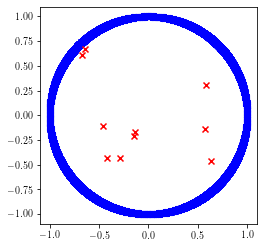

In [5]:
uepd.plot_object(X, X_noise)

In [6]:
dgm_tot = uepd.alphacomplex(X_tot)
dgm_true = uepd.alphacomplex(X)

In [7]:
nb_points_samples = 100
nb_repeat = 100

In [8]:
# Resolution parameters
m=-0.1
M=1.1

In [9]:
diags = uepd.expected_dgm(X_tot, nb_points_samples, nb_repeat)
h = uepd.tohist(diags, m=m, M=M)

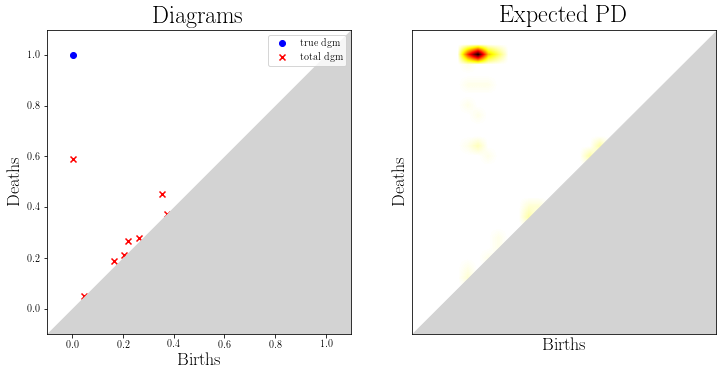

In [10]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
uepd.plot_dgm(dgm_true, dgm_tot, m = m, M=M, ax=ax1)
uepd.plot_hist(h, ax=ax2)

As one can see, the expected persistence diagram is much more similar to the true diagram (blue point) than the diagram one would obtain by considering the whole point cloud directly (red crosses)!